In [2]:
import json
from typing import Tuple, List, Dict, TypedDict, Optional

import torch
from torch import Tensor
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from scipy.io import loadmat
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from PIL import Image, ImageDraw, JpegImagePlugin, ImageFont

## Getting Faster-CNN pretrained model


In [3]:
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)



Getting index of the Person class


In [4]:
def build_image_name(image_id: int) -> str:
    return f'{str(image_id).rjust(12, "0")}.jpg'


def get_images_with_person(number_of_images: int = 10) -> List[int]:
    with open('./annotations/instances_val2017.json', 'r') as _f:
        instances = json.load(_f)
#         print(f'All keys are {instances.keys()}')
#         print(f'Images {instances["images"][0]}')
#         print(f'Annotation {instances["annotations"][0]}')
        for category in instances['categories']:
            if category['supercategory'] == 'person':
                print(f'Category Person with id: {category["id"]}')

        persons_images = []
        for ann in instances['annotations']:
            if number_of_images:
                if ann['category_id'] == 1:
                    persons_images.append(build_image_name(ann['image_id']))
                    number_of_images -= 1
    return persons_images
    


In [5]:
FONT = ImageFont.truetype('/usr/share/fonts/truetype/freefont/FreeSerif.ttf', 12)
def draw_key_points(img: Image.Image, key_points: List[Tuple[str, List]]) -> Image.Image:
    drawing = ImageDraw.Draw(img)
    for point in key_points:
        if point[1][2] != 0:
            # drawing.point(xy=[point[1][0], point[1][1]], fill='blue')
            drawing.ellipse(xy=[point[1][0], point[1][1], point[1][0] + 3, point[1][1] + 3], fill='blue')
            drawing.text((point[1][0], point[1][1]), text=point[0], font=FONT)
    return img

In [6]:
def group_by_n_elements(iterable: List, number_of_elements: int) -> List:
    return [iterable[x: x + number_of_elements] for x in range(0, len(iterable), number_of_elements)]

In [7]:
def group_with_body_parts(coordinates: List) -> List:
    body_parts = ['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle']
    grouped = group_by_n_elements(iterable=coordinates, number_of_elements=3)
    result = itertools.zip_longest(body_parts, grouped)
    return list(result)

In [8]:
def draw_bbox(img: JpegImagePlugin.JpegImageFile, points: Tuple[float, float, float, float]) -> ImageDraw.Draw:
    """Draws bbox on the image"""
    x_coord, y_coord, width, height = points
    img = img.convert('RGBA')
    overlay = Image.new('RGBA', img.size, (255, 255, 255, 0))
    draw = ImageDraw.Draw(overlay)
    draw.rectangle((
        (x_coord, y_coord), 
        (x_coord + width, y_coord + height)), 
        fill=(128,255,255,90), 
        outline=(210,255,255,120),
        width=3
    )
    return Image.alpha_composite(img, overlay)

In [9]:
def crop_bbox(img: JpegImagePlugin.JpegImageFile, points: Tuple[float, float, float, float]) -> ImageDraw.Draw:
    to_return = img.resize((256, 192), box=(points[0], points[1], points[0] + points[2], points[1] + points[3]))
    return to_return

NameError: name 'persons_images' is not defined

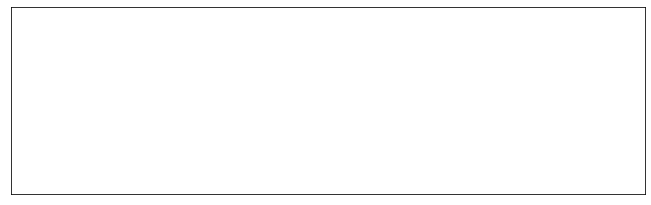

In [9]:
fig = plt.figure(figsize=(25, 20))

cropped_images = []
for idx in range(5):
    ax = fig.add_subplot(5, 2, idx + 1, xticks=[], yticks=[])
    target_image = build_image_name(image_id=persons_images[idx]['image_id'])
    with Image.open(f'./val2017/{target_image}') as im:
        # image_with_bbox = draw_bbox(img=im, points=persons_images[idx]['bbox'])
        # image_with_points = draw_key_points(img=im, key_points=group_with_body_parts(persons_images[idx]['keypoints']))
#         cropped_image = crop_bbox(img=image_with_points, points=persons_images[idx]['bbox'])
#         cropped_images.append(cropped_image)
        plt.imshow(im)
        ax.set_title('person')
plt.show()

In [10]:
target_image = build_image_name(image_id=persons_images[0]['image_id'])

to_torch = transforms.ToTensor()
with Image.open(f'./val2017/{target_image}') as im:
    tensor_image = to_torch(im)
    print(type(tensor_image))
    print(tensor_image.size())
    model.eval()
    output = model([tensor_image, ])

NameError: name 'persons_images' is not defined

In [11]:
boxes = output[0]['boxes']
labels = output[0]['labels']
scores = output[0]['scores']

to_be_displayed = []
for index, score in enumerate(scores):
    if score > 0.5000:
        to_be_displayed.append({'box': boxes[index], 'label': labels[index], 'score': score})

NameError: name 'output' is not defined

### Displaying all objects and there classes on the image

In [12]:
image_to_display = im.copy()
for index, image_data in enumerate(to_be_displayed):
    if image_data['label'].item() == 1:
        image_to_display = draw_bbox(img=image_to_display, points=image_data['box'])
plt.imshow(image_to_display)  

NameError: name 'im' is not defined

In [10]:
model.eval()

class DetectedPersons(TypedDict):
    image: Optional[ImageDraw.Draw]
    boxes: List[Tensor]
        

def detect_person(path_to_image: str) -> DetectedPersons:
    """Detects persons on image and returns image with blist of bounding boxes"""
    data_to_return = {'image': None, 'boxes': []}
    with Image.open(path_to_image) as im:
        
        to_torch = transforms.ToTensor()
        tensor_image = to_torch(im)
        output = model([tensor_image, ])
        if output:
            output = output[0]
            
            for idx, label in enumerate(output['labels']):
                if label.item() == 1:  # if class number is 1
                    data_to_return['boxes'].append(output['boxes'][idx])
                    im = draw_bbox(img=im, points=output['boxes'][idx])

    data_to_return['image'] = im
    return data_to_return
        

In [1]:
fig = plt.figure(figsize=(25, 20))

image_ids = get_images_with_person(number_of_images=1)

for idx, image_path in enumerate(image_ids):
    result = detect_person(path_to_image=f'./val2017/{image_path}')
    ax = fig.add_subplot(5, 3, idx + 1, xticks=[], yticks=[])
    ax.set_title('Person')
    
plt.show()

NameError: name 'plt' is not defined